*Master IASD, PSL - 2023/2024 - O. Cappé, February 2024*

# Retail Store Management

**This is your INDIVIDUAL homework that needs to be returned by March 25, 2024, at the latest, as a functional completed Python notebook file. Late submissions will be applied a penalty.** Please print your name here and be sure to name your file <code>YourFirstName-YOURLASTNAME-retail_store.ipynb</code> and to send it by email to <olivier.cappe@ens.fr> before the deadline.

We consider, the retail store management model seen in the first course.

You own a bike store. During week $t$, the demand is $D_t$ units, which we may assume to be $\operatorname{Poisson}(d)$ distributed, independently of the past. On Monday morning you may choose to command $A_t$ additional units that are delivered immediately before the shop opens. For each week,

- Maintenance Cost: $h$ per unit left in your stock from previous week
- Ordering Cost: $c$ per ordered unit
- Sales Profit: $f$ per sold unit

With the following constraints

- Your warehouse has a maximal capacity of $m$ unit (any additional bike gets stolen)
- You cannot sell bikes that you don’t have in stock

We will consider that $\mathcal{A}=\mathcal{S}=\{0,\dots,m\}$ and the MDP evolves according to

- $D_t \sim \operatorname{Poisson}(d)$
- $X_t = -h S_t -c A_t + f \min(D_t, S_t + A_t, m)$
- $S_{t+1} = \max(0, \min(S_t+A_t,m)-D_t)$

In [2]:
# Please REFRAIN from importing any additional module
import math
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt

## The Retail Store Environment

The <code>RetailStore</code> class defines the environnement, providing the basic functions for interacting with the system (<code>env.reset</code> and <code>env.step</code>) and for computing basic parameter-dependent quantities (reward and transition functions, value function of a policy).

In [3]:
# Utility functions for the Retail store environment (do NOT modify this code block)

class RetailStore:
    def __init__(self, m, h, c, f, d):
        self.m = m # Stock capacity
        self.h = h # Maintenance cost per unit
        self.c = c # Buying price per unit
        self.f = f # Selling price per unit
        self.d = d # Weekly average demand

    def reset(self, state):
        """ Restarts the environment at time 0 in specified state. """
        self.state = state
        self.time = 0

    def step(self, action):
        """ Given the action, performs one call to the environment and return the reward. """
        demand = poisson.rvs(self.d)
        reward = -self.h*self.state -self.c*action + self.f*min([demand, self.state+action, self.m])
        # Update the time and state variables
        self.time += 1
        self.state = max([min([self.state+action, self.m])-demand, 0])
        return reward

    def reward_function(self):
        """ Computes the action-depend reward function r(s,a). """
        r = np.zeros((self.m+1, self.m+1))
        for s in range(self.m+1):
            for a in range(self.m+1):
                # Note: computing the expectation of the truncated Poisson distribution using the survival function
                r[s, a] = -self.h*s -self.c*a + self.f*sum(poisson.sf(np.linspace(0, min(s+a, self.m)-1, num=min(s+a, self.m)), self.d))
        return r

    def transition_function(self):
        """ Computes the action-depend transition probabilities p(s,a,s'). """
        p = np.zeros((self.m+1, self.m+1, self.m+1))
        for s in range(self.m+1):
            for a in range(self.m+1):
                for i in range(min(s+a, self.m)):
                    p[s, a, min(s+a, self.m)-i] = poisson.pmf(i, self.d)
                p[s, a, 0] = poisson.sf(min(s+a, self.m)-1, self.d)
        return p

    def reward_policy(self, pi):
        """ Computes the reward function r_pi(s) associated with a policy. """
        r = self.reward_function()
        r_pi = np.sum(np.multiply(r, pi), axis=1)
        return r_pi

    def transition_policy(self, pi):
        """ Computes the transition probabilities p_pi(s,s') associated with a policy. """
        p = self.transition_function()
        p_pi = np.zeros((self.m+1, self.m+1))
        for s in range(self.m+1):
            p_pi[s,:] = np.matmul(np.transpose(pi[s,:]), p[s,:,:])
        return p_pi

    def value_policy(self, pi, gamma):
        """ Computes the value function of a policy, with discount gamma (using matrix inversion). """
        r_pi = self.reward_policy(pi)
        p_pi = self.transition_policy(pi)
        v_pi = np.linalg.solve(np.eye(self.m+1) - gamma* p_pi, r_pi)
        return v_pi

## Experiments

### Q1. Simulation of Fixed Ordering Policies

We will consider a small-size model in which $[m, h, c, f, d, \gamma] = [9, 0.1, 0.5, 1, 4, 0.875]$ **(Comment these choice of parameters).** By simulating trajectories from the model **(discuss what length is necessary)** get an empirical idea of **how well fixed-ordering (i.e. ordering always the same quantity of goods) perform?** Use the <code>env.value_policy</code> to **plot the value functions of the fixed-ordering policies.** **What is your interpretation of the results? Do you think that there are better policies?**

Trajectory simulation of 50 weeks for action 3
0 :  2.6  -> 4
1 :  -0.9  -> 6
2 :  0.9  -> 6
3 :  0.9  -> 6
4 :  0.9  -> 6
5 :  1.9  -> 5
6 :  0.0  -> 6
7 :  1.9  -> 5
8 :  -1.0  -> 7
9 :  0.8  -> 6
10 :  1.9  -> 5
11 :  5.0  -> 1
12 :  0.4  -> 2
13 :  1.3  -> 2
14 :  3.3  -> 0
15 :  1.5  -> 0
16 :  0.5  -> 1
17 :  1.4  -> 1
18 :  1.4  -> 1
19 :  0.4  -> 2
20 :  -0.7  -> 4
21 :  1.1  -> 4
22 :  0.1  -> 5
23 :  3.0  -> 3
24 :  2.2  -> 2
25 :  3.3  -> 0
26 :  1.5  -> 0
27 :  1.5  -> 0
28 :  1.5  -> 0
29 :  1.5  -> 0
30 :  -0.5  -> 2
31 :  0.3  -> 3
32 :  4.2  -> 0
33 :  -0.5  -> 2
34 :  3.3  -> 0
35 :  1.5  -> 0
36 :  -0.5  -> 2
37 :  1.3  -> 2
38 :  0.3  -> 3
39 :  -0.8  -> 5
40 :  0.0  -> 6
41 :  0.9  -> 6
42 :  1.9  -> 5
43 :  1.0  -> 5
44 :  0.0  -> 6
45 :  2.9  -> 4
46 :  3.1  -> 2
47 :  1.3  -> 2
48 :  3.3  -> 0
49 :  1.5  -> 0
Discounted reward: 8.9


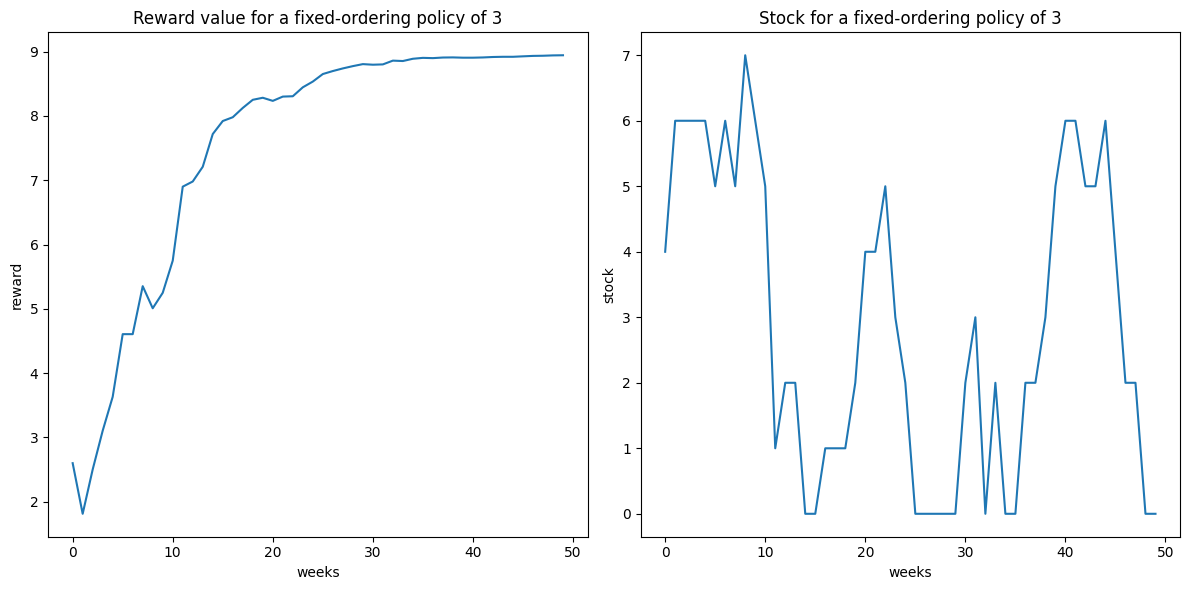

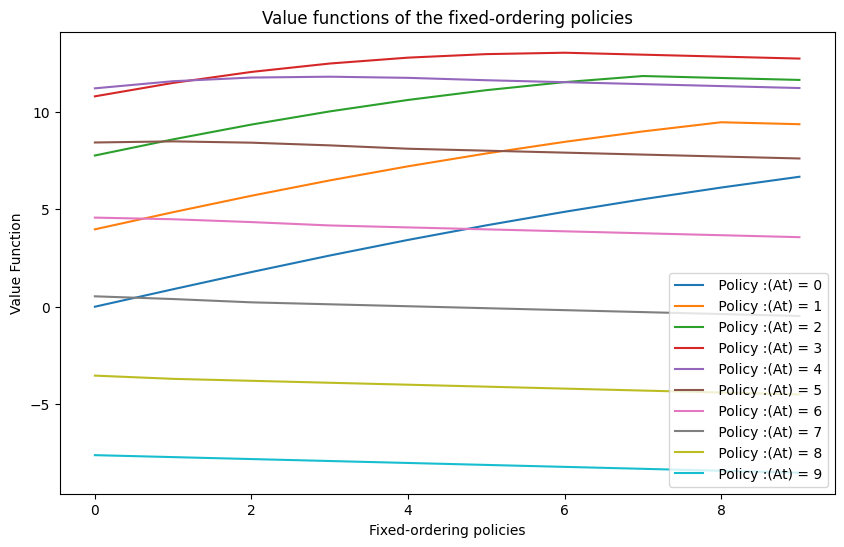

In [5]:
# Instantiate the retail store environment with the selected parameters
[m, h, c, f, d, gamma] = [9, 0.1, 0.5, 1, 4, 0.875]
env = RetailStore(m, h, c, f, d)

# Just an example of simulating a short trajectory and computing the cumulated reward
#env.reset(m)
#n = 12
#w = 1
#v = 0
#for _ in range(n):
#    x = env.step(3)
#    print(env.time-1, ': ', '{:.1f}'.format(x), ' ->', env.state)
#    v += w*x
#    w *= gamma
#print('Discounted reward:', '{:.1f}'.format(v))

# --- Your answer here ---

#Simulating long trajectories and computing the cumulated reward
#Example for action 3 and trajectory of 50 weeks

print('Trajectory simulation of 50 weeks for action 3')
env.reset(m)
n = 50
w = 1
v = 0
reward=[]
stock=[]
for _ in range(n):
    x = env.step(3)
    print(env.time-1, ': ', '{:.1f}'.format(x), ' ->', env.state)
    v += w*x
    reward.append(v)
    stock.append(env.state)
    w *= gamma
print('Discounted reward:', '{:.1f}'.format(v))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(n), reward)
plt.title("Reward value for a fixed-ordering policy of 3")
plt.xlabel("weeks")
plt.ylabel("reward")
plt.subplot(1, 2, 2)
plt.plot(range(n), stock)
plt.title("Stock for a fixed-ordering policy of 3")
plt.xlabel("weeks")
plt.ylabel("stock")
plt.tight_layout()
plt.show()

#Plotting the function values for the fixed ordering policy

Fixed_policies = list(range(env.m+1))

value_functions = []
for pol in Fixed_policies:
    fixed_policy= np.zeros((env.m +1,env.m + 1))
    fixed_policy[:,pol] = 1
    value_functions.append(env.value_policy(fixed_policy,gamma))

plt.figure(figsize=(10, 6))
for i, pol in enumerate(Fixed_policies):
    plt.plot(range(m + 1), value_functions[i], label=f" Policy :(At) = {pol}")

plt.xlabel('Fixed-ordering policies')
plt.ylabel('Value Function')
plt.title('Value functions of the fixed-ordering policies')
plt.legend()
plt.show()

**Commenting parameters, discussing length, how well fixed-ordering perform?**

Firstly, with a discount factor (gamma) set at 0.875,the store manager prioritizes long-term rewards, recognizing the significance of future outcomes in decision-making processes.
Moreover, the store's stock capacity is set at 9 bikes, the stratagy aims to maintain a manageable inventory level. The low maintenance cost per unit (0.1) suggests a prudent approach to stock management, avoiding excessive costs.
The pricing strategy, with a purchase price of 0.5 and a selling price of 1 per unit, indicates a focus on maintaining reasonable profit margins.
Considering the demand aspect, the average weekly demand of 4 units, following a Poisson distribution, highlights the inherent variability in customer needs. This variance in demand poses a challenge to fixed ordering policies, as they may struggle to adapt effectively to fluctuations in customer demand.

To confirm this, we simulated trajectories for different fixed actions.The plot example is a simulation for action 3. After many tests simulations, it seems that longer trajectories (50 for example) might be necessary to observe long term trends.

We notice that both the reward function and the stock under a fixed ordering policy exhibit very high variance during simulations. At times, the stock level can be excessively high compared to demand, leading to unnecessary storage costs.
It confirms our intuition about the fact that the fixed ordering policy is not optimal.


**Commenting on the value functions of fixed ordering policies**

We can observe that there is no curve that always outperforms the others which shows that there isn't a singular optimal fixed ordering policy (even if 3 seems to be the best, 4 outperforms 3 at first). Instead, it indicates that the actions must be adjusted based on the current state of the store.
Also, it appears that negative newards are obtained for some fixed policies (7,8,9).
This is due to the fact that fixed ordering doesn't adapt well to the demand fluctuation (for example, when demand is low and a large order results in losses for the retail store manager : for a demand of 4 and 8 units to command when the store does not contain the 4 others).
We can thus conclude that the fixed ordering policy is not optimal and can bee seen as overly cautious.We need a more adaptive approach.







### Q2. Computing the Optimal Policy
Obtain the optimal policy by **implementing the Policy Iteration algorithm** (use the <code>env.value_policy</code> to compute the value function). **How do you know that it has converged?** **What does the optimal policy do?** **Comment the form of the value function.**

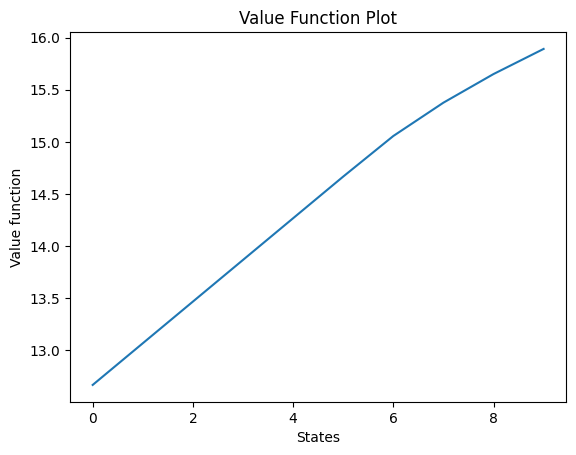

In [10]:
#Policy Iteration Algo
def update_policy(env, pi, gamma):
    rewards = env.reward_function()
    value_f = env.value_policy(pi, gamma)
    new_pol = np.zeros((env.m + 1, env.m + 1))
    for s in range(env.m + 1):
        result = rewards[s, :] + gamma * np.matmul(env.transition_function()[s, :, :], value_f)
        best_pol = np.argmax(result)
        new_pol[s][best_pol] = 1
    return new_pol

def optimal_policy_algo(env, gamma=0.875, epsilon=0.01):
    policy = np.zeros((env.m+1,env.m+1))
    value_f = env.value_policy(policy,gamma)
    new_pol = update_policy(env,policy,gamma)
    new_value_f = env.value_policy(new_pol,gamma)

    while not np.linalg.norm(new_value_f-value_f, ord=np.inf)<= (1 - gamma) / (gamma * epsilon):
        policy = new_pol
        value_f = new_value_f
        new_pol = update_policy(env, policy, gamma)
        new_value_f = env.value_policy(new_pol, gamma)

    return new_pol, new_value_f

opt_pol, opt_value_f = optimal_policy_algo(env)
plt.plot(opt_value_f)
plt.title("Value Function Plot")
plt.xlabel("States")
plt.ylabel("Value function")
plt.show()

 **How do you know that it has converged?**

We determine convergence by comparing the absolute difference between the new and old value functions. We stop when there is no significant increase in the value function. If this difference is less than a certain threshold (determined by the formula (1 - γ) / (γ * ε)), where ε is a predefined small value (in this case, 0.01), then we consider the algorithm to have converged.

**Comment the form of the value function.**

The observed increase in the value function appears to be nearly linear, starting from approximately 12,5 at week 1 (state 0) and reaching close to 16 at week 9 (state 8). This linear trend indicates a consistent growth in expected returns as we progress through the weeks.
It could be attributed to the cumulative effect of sales profits, which gradually accumulate over time. As each week passes, the potential for sales increases, contributing to a gradual rise in the expected returns reflected in the value function.
Moreover, the linear increase suggests that the retail store's operations are relatively stable over the considered time horizon. It implies that the inventory management policies implemented, are effectively balancing costs and profits, resulting in a steady growth trajectory for the expected returns.

In [7]:
for a in range(env.m + 1):
    act = np.argmax(opt_pol[a, :])
    print(f"In state {a}: order {act} bikes ")

In state 0: order 5 bikes 
In state 1: order 4 bikes 
In state 2: order 3 bikes 
In state 3: order 2 bikes 
In state 4: order 1 bikes 
In state 5: order 0 bikes 
In state 6: order 0 bikes 
In state 7: order 0 bikes 
In state 8: order 0 bikes 
In state 9: order 0 bikes 


**What does the optimal policy do?**
The optimal policy dictates the best action to take in each state to maximize the expected cumulative reward over time.
In this case, we observe that the optimal policy aims to maintain a stock level close to the mean of the demand distribution. If the current stock level exceeds the mean demand, no additional bikes are ordered to avoid unnecessary inventory accumulation. This strategy helps balance inventory costs with the need to meet customer demand.


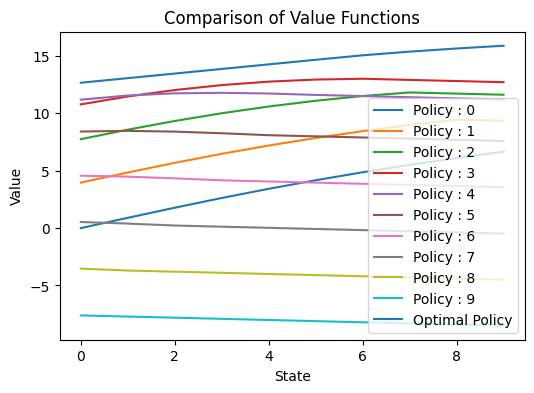

In [9]:
# Comparing to fixed ordering policies
policies = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
fonction_values = []
for p in policies:
    fixed = np.zeros((env.m + 1, env.m + 1))
    for i in range(env.m + 1):
        fixed[i][p] = 1
    fonction_values.append(env.value_policy(fixed, gamma))

fonction_values.append(opt_value_f)

plt.figure(figsize=(6, 4))
for i in range(len(fonction_values)):
    if i != len(fonction_values) - 1:
        plt.plot(fonction_values[i], label=f'Policy : {i}')
    else:
        plt.plot(fonction_values[i], label='Optimal Policy')

plt.title("Comparison of Value Functions")
plt.xlabel("State")
plt.ylabel("Value")
plt.legend()
plt.show()

### Q3. Q Learning
**Implement the asynchronous Q-Learning algorithm using the purely random policy (all actions selected uniformly) as the exploration policy** (note: this requires only about 10 lines of code). **Plot the convergence of the algorithm** both in terms of convergence of the state-action value table $Q_t$ and of convergence of the value function of the associated greedy policy $\pi_{t+}(s) = \arg\max_a Q_t(s,a)$. Use a single trajectory of length $n = 10,000$ and **test different schemes of decrease** of the learning rate (following the course guidelines).

In [16]:
from tqdm import tqdm
def power(n,b):
    return 1/np.power(n,b)

def optimal_q(policy,env,gamma):
    probs = env.transition_function()
    rewards = env.reward_function()
    value_f = env.value_policy(policy,gamma)
    Q_star = np.zeros((env.m+1,env.m+1))
    for i in range(env.m+1):
        Q_star[i] = rewards[i,:] + gamma*np.matmul(probs[i,:,:],value_f)
    return Q_star

def greedy_policy(q_table,env):
    pol = np.zeros((env.m +1,env.m +1))
    for state in range(env.m + 1):
        best_action = np.argmax(q_table[state,:])
        pol[state,best_action] = 1
    return pol

In [17]:
def A_Q_L(env,gamma,beta,n,optimal_pol):
    diff_q_list = []
    diff_v_list = []
    N = np.zeros((env.m+1,env.m+1))
    Q_star = np.zeros((env.m+1,env.m+1))
    actions = list(range(env.m +1))
    env.reset(np.random.choice(actions))
    new_s = env.state
    opt_table = optimal_q(opt_pol,env,gamma)
    opt_value = env.value_policy(opt_pol,gamma)
    for i in tqdm(range(n)):
        s = new_s
        a = np.random.choice(actions)
        N[s,a] += 1
        reward = env.step(a)
        new_s = env.state
        Q_star[s,a] += power(N[s,a],beta)*(reward + gamma * np.max(Q_star[s,:]) - Q_star[s,a])
        diff_q_list.append(np.linalg.norm(Q_star - opt_table))
        greedy_pol = greedy_policy(Q_star,env)
        greedy_val = env.value_policy(greedy_pol,gamma)
        diff_v_list.append(np.linalg.norm(greedy_val - opt_value))
    return Q_star,diff_q_list,diff_v_list

100%|██████████| 10000/10000 [15:32<00:00, 10.72it/s]


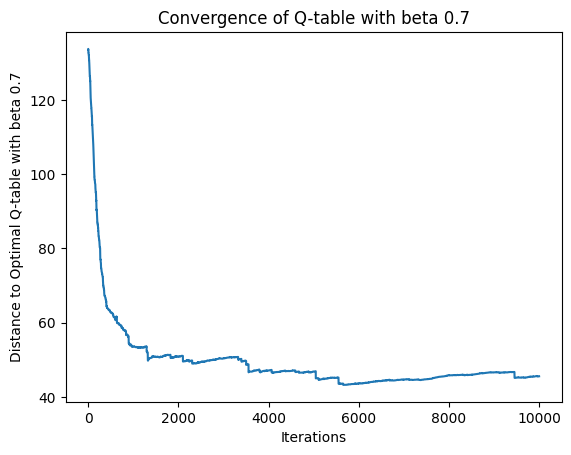

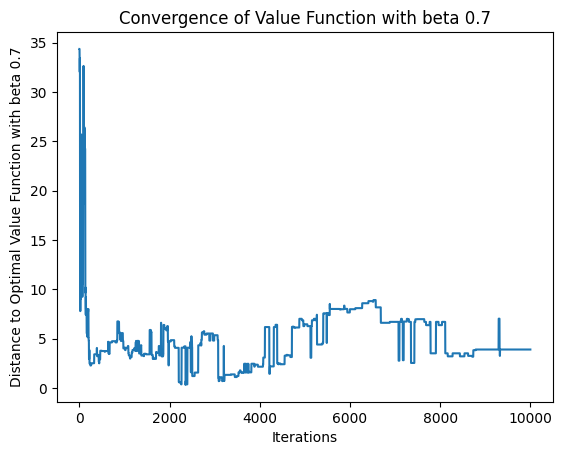

100%|██████████| 10000/10000 [15:53<00:00, 10.49it/s]


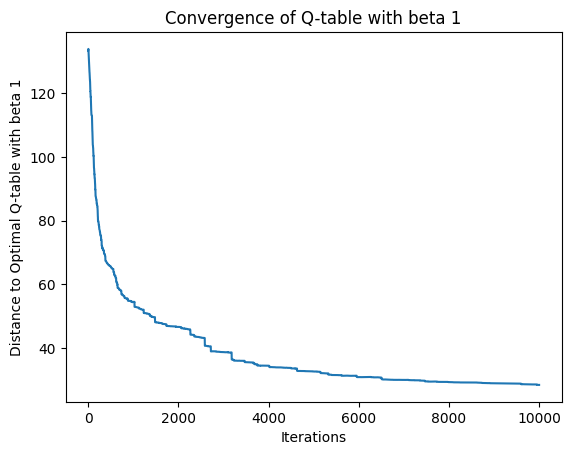

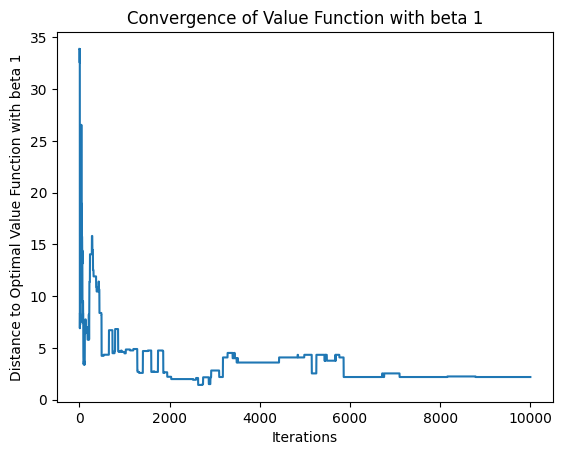

In [18]:
for beta in [0.7,1]:
  Q_star,q_list,v_list = A_Q_L(env,gamma,beta,10000,opt_pol)
  plt.plot(q_list)
  plt.title(f"Convergence of Q-table with beta {beta}")
  plt.xlabel("Iterations")
  plt.ylabel(f"Distance to Optimal Q-table with beta {beta}")
  plt.show()
  plt.plot(v_list)
  plt.title(f"Convergence of Value Function with beta {beta}")
  plt.xlabel("Iterations")
  plt.ylabel(f"Distance to Optimal Value Function with beta {beta}")
  plt.show()

### Q4. Policy Gradient

We will now consider using policy gradient from a set of simulated trajectories using the REINFORCE formula to approximate the gradient of the value function. To do so, we consider a log-linear parameterization of the policy and provide the two utility functions below.

<code>policy_features</code> Computes a $2(m+1)$--dimensional feature vector $\phi(s,a)$ corresponding to the state-action pair $(s,a)$.

<code>policy_choice</code> Computes the vector $\pi_\theta(s,:)$ of action probabilities using the softmax operator:
$$
    \pi_\theta(s,a) = \frac{\exp\left(\theta^T \phi(s,a)\right)}{\sum_{a'=0}^m \exp\left(\theta^T \phi(s,a')\right)}
$$
You should check from the code that the matrix $(\theta^T \phi(s,a))_{0\leq s,a \leq n}$ is a weighted sum of the $m+1$ fixed ordering policies and of the $m+1$ threshold policies (which you should have met already...)

In [19]:
# Policy gradient utility functions (do NOT modify this code block)

def policy_features(s, a, m):
    """Returns the feature vector corresponding to state (s,a)."""
    f = np.zeros(2*(m+1))
    # Index of the fixed ordering policy that is non zero in (s,a)
    f[a] = 1
    # Indices of the threshold policies that are non zero in (s,a)
    if (s+a <= m):
        f[(m+1)+s+a] = 1
    if (a == 0):
        for i in range(0,s+1):
            f[(m+1)+i] = 1
    return f

def policy_choice(s, m,theta):
    """Returns the vector of action probabilities pi(s,:) corresponding to state s and parameter theta."""
    pi = np.zeros(m+1)
    # Note : Computation in log to avoid numerical underflows
    for a in range(m+1):
        pi[a] = np.dot(policy_features(s, a, m), theta)
    pi = pi - np.max(pi)
    pi = np.exp(pi)/np.sum(np.exp(pi))
    return pi

**Code a function** <code>policy_gradient</code> that computes the gradient $\nabla_\theta \log\pi_\theta(s,a)$ of $\pi_\theta(s,a)$. First **write in the text block below the LaTeX formula implemented by the function, explaining how you obtain this formula.**

We first start by taking the log of the funciton :
$$
\log \pi_\theta(s,a) = \left(\theta^T \phi(s,a)\right) - \log\left(\sum_{a'=0}^m \exp\left(\theta^T \phi(s,a')\right)\right)
$$
then we derive it:
$$
\nabla_\theta \log \pi_\theta(s, a) = \phi(s, a) - \frac{1}{\sum_{a'=0}^m \exp\left(\theta^T \phi(s,a')\right)} \sum_{a'=0}^m \exp\left(\theta^T \phi(s,a')\right) \cdot \phi(s, a')
$$
After that we write it:
$$
\nabla_\theta \log \pi_\theta(s, a) = \phi(s, a) -  \sum_{a'=0}^m \frac{\exp\left(\theta^T \phi(s,a')\right)}{{\sum_{x=0}^m \exp\left(\theta^T \phi(s,x)\right)}} \cdot \phi(s, a')
$$
At the end, we obtain:
$$
\nabla_\theta \log \pi_\theta(s, a) = \phi(s, a) -  \sum_{a'=0}^m \pi_\theta(s,a') \cdot \phi(s, a')
$$


In [20]:
def policy_gradient(env,s, a,theta) :
    m=env.m
    pca = policy_choice(s, m, theta)
    pfsa = policy_features(s,a, m)
    gradient = np.sum([pca[x] * policy_features(s, x, m) for x in range(m + 1)]) - pfsa
    return gradient

**Implement the policy gradient algorithm** approximating the gradients using the REINFORCE formula
$$
  \sum_{t=0}^{n} \gamma^t \left(\sum_{i=0}^{n} \gamma^i X_{t+i} \right) \nabla_\theta \log \pi_\theta(S_t, A_t)
$$
computed on trajectories of length 35 started from a random initial state and using 200 iterations of SGD updates. To do so, complete the code template provided below. **Monitor the convergence of the algorithm by plotting the difference between the mean of the optimal value function and the mean of the value functions corresponding to successive values of $\theta$ (explain why one considers the mean).**

In [ ]:
def pol_theta(theta,env):
    pol_estim = np.zeros((env.m+1,env.m+1))
    for s in range(env.m+1):
        pol_estim[s] = policy_choice(s,env.m,theta)
    return pol_estim

100%|██████████| 5/5 [01:33<00:00, 18.77s/it]


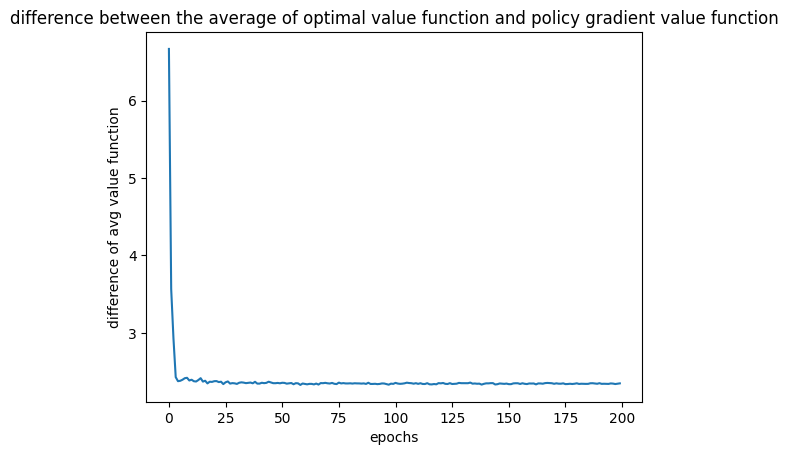

In [ ]:
# POLICY GRADIENT ALGORITHM
trajectory_len = 35
iter = 200
m = env.m
theta = np.zeros(2*(m+1))
mean_opt_val_f = np.mean(env.value_policy(opt_pol,gamma)) # check ici
simulations = []
nb_sim = 5

for _ in tqdm(range(nb_sim)):

    diff_val_f = []
    theta = np.zeros(2*(m+1))

    for it in range(iter):
        init_state = np.random.choice(list(range(env.m)))
        env.reset(init_state)
        trajectories = []
        for step in range(trajectory_len):
            curr_state = env.state
            pc=policy_choice(env.state,m,theta)
            action = np.argmax(pc)
            reward = env.step(action)
            next_state = env.state
            trajectories.append((curr_state,action,next_state,reward))

        X = []
        A = []
        S = []
        for t in trajectories:
            X.append(t[3])
            A.append(t[1])
            S.append(t[0])

        g = np.zeros_like(theta)
        for t in range(trajectory_len):
          sum_k = np.sum([gamma**k * X[t + k] for k in range(trajectory_len - t)])
          g += gamma**t  * sum_k  * policy_gradient(env,S[t], A[t], theta)


        curr_est_pol = pol_theta(theta,env)
        mean_curr_value = np.mean(env.value_policy(curr_est_pol, gamma=gamma))
        gap = np.abs(mean_opt_val_f - mean_curr_value)
        diff_val_f.append(gap)
        theta += 0.1*np.power(1+it, -0.6)*g

    simulations.append(diff_val_f)

simulations = np.mean(np.array(simulations), 0)
plt.plot(range(len(diff_val_f)), simulations)
plt.title("difference between the average of optimal value function and policy gradient value function")
plt.xlabel("epochs")
plt.ylabel("difference of avg value function")
plt.show()


We compute the mean of successive value functions to account for small changes in theta that can influence the probability distribution and final action choice. By averaging these values, we mitigate the impact of fluctuations in theta and obtain a consistent estimate of the value function, providing a stable measure of convergence during training.